# Analyse quasi-steady states for a massless kite

$\mathcal{D}$

In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import yaml

from helper.plotting_settings import set_labels, FULLSIZE, PARTSIZE

In [2]:
# Load the parameter file. These are values that will remain fixed.
with open("../parameters/MegAWES_massless.yaml", "r") as f:
    try:
        params = yaml.safe_load(f)
        kite = params["kite"]
        tether = params["tether"]
        environment = params["environment"]

    except yaml.YAMLError as exc:
        print(exc)

In [3]:
# All combinations of the variables in `ranges` a state will be calculated.
ranges = {
    "vw_mps": np.arange(0, 30.1, 0.1),  # wind speed [m/s]
    "beta_deg": [0.0, 30.0],  # elevation [deg]
    "phi_deg": [0.0, 17.5],  # azimuth [deg]
    "Lt_m": [500, 1000, 1500],  # tether length [m] (no mass effects, just drag).
}

# Make a new DataFrame that expands these ranges in all possible combinations.
# For all combinations we'll calculate the best reeling factor.
df_star = pd.DataFrame(product(*ranges.values()), columns=ranges.keys())

In [4]:
# Quasi-steady model for the ideal reeling factor.
def f_star(beta_deg, phi_deg):
    return 1 / 3 * np.cos(np.deg2rad(beta_deg)) * np.cos(np.deg2rad(phi_deg))


# The effective lift-to-drag ratio is lowered by a certain amount of tether drag.
def E_eff(Lt_m):
    C_D = kite["CL"] / kite["E"]
    C_D_eff = C_D + 0.5 * tether["r_m"] * Lt_m / kite["S_m2"] * tether["Cd_t"]
    return kite["CL"] / C_D_eff


# Quasi-steady model for tether force.
def Ftg(beta_deg, phi_deg, E_eff, vw_mps, f):

    q = 1 / 2 * environment["rho_kgpm3"] * vw_mps**2

    C_R = kite["CL"] * np.sqrt(1 + 1 / E_eff**2)
    return (
        q
        * kite["S_m2"]
        * C_R
        * (1 + E_eff**2)
        * (np.cos(np.deg2rad(beta_deg)) * np.cos(np.deg2rad(phi_deg)) - f) ** 2
    )


# Output power.
def P(vw_mps, f, Ft):
    return vw_mps * f * Ft

In [5]:
# Calculate the ideal state.
df_star = df_star.assign(f_star=lambda row: f_star(row.beta_deg, row.phi_deg))
df_star = df_star.assign(E_eff=lambda row: E_eff(row.Lt_m))
df_star = df_star.assign(
    Ftg_N_star=lambda row: Ftg(
        row.beta_deg,
        row.phi_deg,
        row.E_eff,
        row.vw_mps,
        row.f_star,
    )
)
df_star = df_star.assign(P_W_star=lambda row: P(row.vw_mps, row.f_star, row.Ftg_N_star))

# Calculate the ideal reel-out speed.
df_star["vr_mps_star"] = df_star["f_star"] * df_star["vw_mps"]

In [6]:
df_star.head()


,vw_mps,beta_deg,phi_deg,Lt_m,f_star,E_eff,Ftg_N_star,P_W_star,vr_mps_star
0,0.0,0.0,0.0,500,0.333333,7.455599,0.0,0.0,0.0
1,0.0,0.0,0.0,1000,0.333333,6.702092,0.0,0.0,0.0
2,0.0,0.0,0.0,1500,0.333333,6.086913,0.0,0.0,0.0
3,0.0,0.0,17.5,500,0.317906,7.455599,0.0,0.0,0.0
4,0.0,0.0,17.5,1000,0.317906,6.702092,0.0,0.0,0.0


In [7]:
df_star.to_csv("../results/MegAWES_massless_analytical_star.csv")


In [8]:
# If we're not interested in the maximum instantaneous power, but in all possible
# combinations, we loop over all possible reel-out factors, and also calculate the
# states for those.
ranges = {
    "vw_mps": np.arange(0, 30.5, 0.5),  # wind speed [m/s]
    "beta_deg": [0.0, 30.0],  # elevation [deg]
    "phi_deg": [0.0, 17.5],  # azimuth [deg]
    "Lt_m": [500, 1000, 1500],  # tether length [m] (no mass effects, just drag).
    "f": np.arange(-1.0, 1.0, 0.01),  # reeling speed [-].
}

# Make a new DataFrame that expands these ranges in all possible combinations.
df = pd.DataFrame(product(*ranges.values()), columns=ranges.keys())

df = df.assign(E_eff=lambda row: E_eff(row.Lt_m))
df = df.assign(
    Ftg_N=lambda row: Ftg(
        row.beta_deg,
        row.phi_deg,
        row.E_eff,
        row.vw_mps,
        row.f,
    )
)
df.loc[(np.cos(np.deg2rad(df.beta_deg)) * np.cos(np.deg2rad(df.phi_deg)) - df.f) < 0, 'Ftg_N'] = np.nan
df = df.assign(P_W=lambda row: P(row.vw_mps, row.f, row.Ftg_N))

df["vr_mps"] = df["f"] * df["vw_mps"]
df.to_csv("../results/MegAWES_massless_analytical.csv")

# Plotting
Let's see what this looks like.

In [9]:
from helper.plotting_settings import set_labels, FULLSIZE, PARTSIZE
import helper.my_plotly_themes

# Interactive matplotlib plots when using vscode
%matplotlib widget

On this screen 15.75 cm is 675 pixels wide.


In [10]:
# Check at which reeling factor the optimal power output lies.

temp = df[
    (df['Lt_m'] == 1000)
    & (df['vw_mps'] == 10)
    ]

px.line(
    temp,
    x='f',
    y='P_W',
    color='beta_deg',
    symbol='phi_deg',
)

In [11]:
# Plotting the maximum instantaneous power output (`P_W_star`) over all wind speeds, for
# different elevation, azimuth, and tether length.
px.line(
    df_star,
    x="vw_mps",
    y="P_W_star",
    color="beta_deg",
    symbol="phi_deg",
    facet_col="Lt_m",
)

In [12]:
temp

,vw_mps,beta_deg,phi_deg,Lt_m,f,E_eff,Ftg_N,P_W,vr_mps
48200,10.0,0.0,0.0,1000,-1.00,6.702092,3.080317e+06,-3.080317e+07,-10.0
48201,10.0,0.0,0.0,1000,-0.99,6.702092,3.049591e+06,-3.019095e+07,-9.9
48202,10.0,0.0,0.0,1000,-0.98,6.702092,3.019018e+06,-2.958638e+07,-9.8
48203,10.0,0.0,0.0,1000,-0.97,6.702092,2.988600e+06,-2.898942e+07,-9.7
48204,10.0,0.0,0.0,1000,-0.96,6.702092,2.958336e+06,-2.840003e+07,-9.6
...,...,...,...,...,...,...,...,...,...
50195,10.0,30.0,17.5,1000,0.95,6.702092,NaN,NaN,9.5
50196,10.0,30.0,17.5,1000,0.96,6.702092,NaN,NaN,9.6
50197,10.0,30.0,17.5,1000,0.97,6.702092,NaN,NaN,9.7
50198,10.0,30.0,17.5,1000,0.98,6.702092,NaN,NaN,9.8


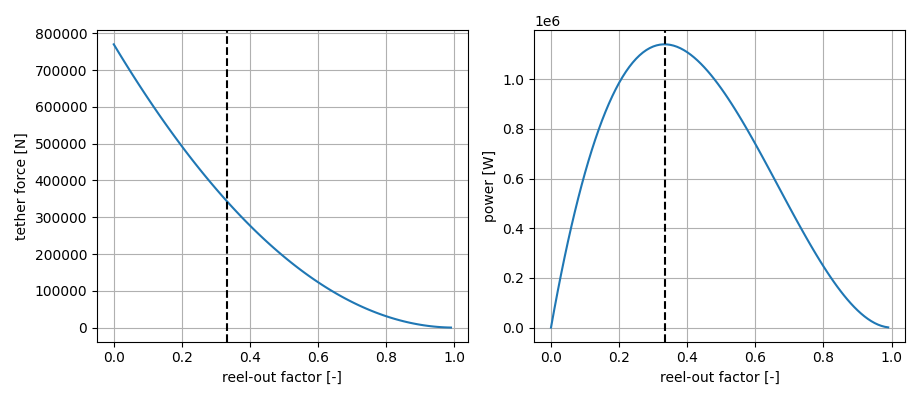

In [13]:
# I sometimes switch to seaborn/matplotlib because some subplots are extremely tedious
# to make with plotly. I especially found margins and stuff to be a pain.
fig, axs = plt.subplots(1, 2, figsize=FULLSIZE)

temp = df[
    (df["vw_mps"] == 10)
    & (df["beta_deg"] == 0)
    & (df["phi_deg"] == 0)
    & (df["Lt_m"] == 1000)
    & (df['f'] >= 0)
]

ys = ["Ftg_N", "P_W"]
for ax, y in zip(axs, ys):
    sns.lineplot(data=temp, x="f", y=y, ax=ax)
    ax.grid()
    ax.axvline(1/3, ls='--', c='k')

set_labels(axs)
plt.tight_layout()
plt.savefig("../results/FP_over_f.png")

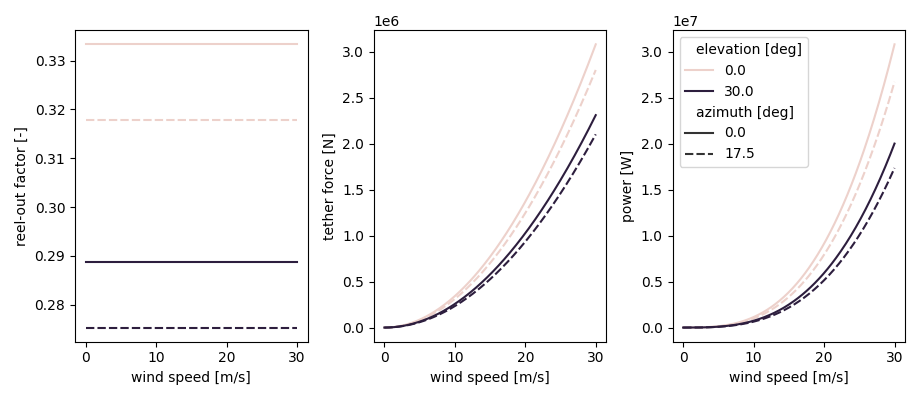

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15.75 / 2.54 + 3, 4))

temp = df_star[df_star["Lt_m"] == 1000]

ys = ["f_star", "Ftg_N_star", "P_W_star"]
for i, y in enumerate(ys):
    sns.lineplot(
        data=temp,
        x="vw_mps",
        y=y,
        hue="beta_deg",
        style="phi_deg",
        ax=axs[i],
        legend=True if i == 2 else False,
    )
    
set_labels(axs)
plt.tight_layout()

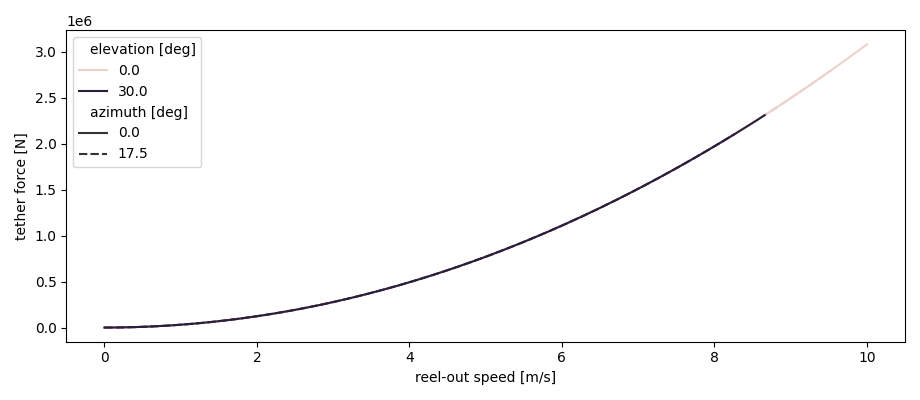

In [15]:
# This is a very interesting figure. It plots the ideal vr-Ft graph. If the winch
# ensures that the kite stays on this optimal vr-Ft line, it will operate at optimal
# (instantaneous) power output. As you can see, the lines for different elevation and
# azimuth are on top of each other. So one strategy can be used (when ignoring the
# effect of tether length and mass).
fig, ax = plt.subplots(1, 1, figsize=(15.75 / 2.54 + 3, 4))

sns.lineplot(
    data=temp,
    x="vr_mps_star",
    y="Ftg_N_star",
    hue="beta_deg",
    style="phi_deg",
    ax=ax,
)


set_labels(ax)
plt.tight_layout()

In [16]:
df.columns

Index(['vw_mps', 'beta_deg', 'phi_deg', 'Lt_m', 'f', 'E_eff', 'Ftg_N', 'P_W',
       'vr_mps'],
      dtype='object')

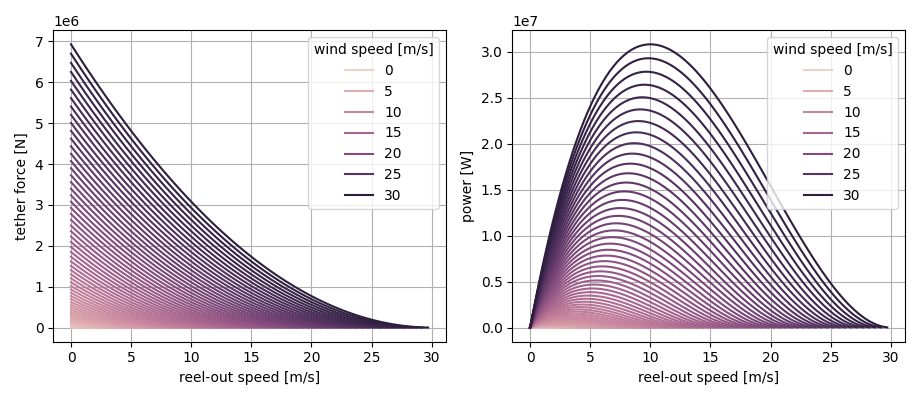

In [17]:
fig, axs = plt.subplots(1, 2, figsize=FULLSIZE)

temp = df[
    # (df["vw_mps"] == 10)
    (df["beta_deg"] == 0)
    & (df["phi_deg"] == 0)
    & (df["Lt_m"] == 1000)
    & (df['f'] >= 0)
]

ys = ["Ftg_N", "P_W"]
for ax, y in zip(axs, ys):
    sns.lineplot(data=temp, x="vr_mps", y=y, ax=ax, hue='vw_mps')
    ax.grid()
    # ax.axvline(1/3, ls='--', c='k')

set_labels(axs)
plt.tight_layout()